# Assignment III.
### *Stochastic Simulation*
#### Group 6
- Marcell Szegedi - 15722635
- Yuxin Dong - 15550397
- Koen Verlaan - 11848316

**Git Repository**: https://github.com/MarcellSzegedi/Stochastic_Simulation_Assignments.git

---
**Import Libraries**

In [37]:
from IPython.display import clear_output
import os

import numpy as np
import matplotlib.pyplot as plt
import math
import random

**Global Output Folders**

In [49]:
temp_output_loc = r"Figures/temp_figures"

**Additional Functions**

In [40]:
# Initialise tour
def tour_initialisation(dist_matrix: np.ndarray) -> list:
    tour_length = dist_matrix.shape[0]
    initial_tour = list(range(tour_length))
    np.random.shuffle(initial_tour)
    return initial_tour


# Function to compute the distance matrix based on Euclidean distance
def compute_distance_matrix(coords: list):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist_matrix


# Function to calculate total distance of a tour
def total_distance(tour: list, dist_matrix: np.ndarray):
    return sum(dist_matrix[tour[i], tour[i + 1]] for i in range(len(tour) - 1)) + dist_matrix[tour[-1], tour[0]]

**Local Search Algorithm**

In [41]:
# 2-opt method
def two_opt_method(tour: np.ndarray) -> np.ndarray:
    idx_to_swap = get_swap_indices(tour)
    print(idx_to_swap)
    return np.concatenate((tour[:idx_to_swap[0]], tour[idx_to_swap[0]:idx_to_swap[1] + 1][::-1], tour[idx_to_swap[1] + 1:]))


# Choose two non-adjacent cities from the tour to be swapped
def get_swap_indices(tour: np.ndarray) -> np.ndarray:
    idx_to_swap = np.random.choice(list(range(len(tour))), size=2, replace=False)
    return np.sort(idx_to_swap) if np.subtract(idx_to_swap[0], idx_to_swap[1]) > 1 else get_swap_indices(tour)

**Cooling Functions**

In [42]:
def cooling_schedule_geometric(temperature, cooling_rate, initial_temp, iteration):
    return temperature * cooling_rate


def cooling_schedule_linear(temperature, cooling_rate, initial_temp, iteration):
    return max(temperature - cooling_rate, 0)


def cooling_schedule_logarithmic(temperature, cooling_rate, initial_temp, iteration):
    return initial_temp / (1 + cooling_rate * np.log(iteration + 1))


def cooling_schedule_reciprocal(temperature, cooling_rate, initial_temp, iteration):
    return initial_temp / (1 + cooling_rate * iteration)

**Utility Functions**

In [43]:
# Read TSPLIB format files and returns the coordinates as a numpy array
def read_tsp(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    coords_start = lines.index('NODE_COORD_SECTION\n') + 1
    coords_end = lines.index('EOF\n')
    coords = []
    for line in lines[coords_start:coords_end]:
        _, x, y = line.split()
        coords.append((float(x), float(y)))
    return np.array(coords)

**Main Annealing Function**

In [44]:
def simulated_annealing(coords, initial_temp, cooling_schedule, cooling_rate, max_iterations, markov_chain_length):
    dist_matrix = compute_distance_matrix(coords)
    n = len(coords)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_distance = total_distance(current_tour, dist_matrix)
    best_tour = current_tour.copy()
    shortest_distance = current_distance

    temperature = initial_temp
    distances = []

    for iteration in range(max_iterations):
        for _ in range(markov_chain_length):
            # 2-opt method
            i, j = sorted(random.sample(range(n), 2))
            new_tour = current_tour[:i] + current_tour[i:j + 1][::-1] + current_tour[j + 1:]
            new_distance = total_distance(new_tour, dist_matrix)

            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temperature):
                current_tour = new_tour
                current_distance = new_distance

            if current_distance < shortest_distance:
                best_tour = current_tour
                shortest_distance = current_distance

        distances.append(shortest_distance)

        # Use the cooling schedule function
        temperature = cooling_schedule(temperature, cooling_rate, initial_temp, iteration)
        if temperature < 1e-8:
            temperature = 1e-8

    return best_tour, shortest_distance, distances

## Calculating the Cooling Functin Parameters

In [72]:
# Data
file_path = 'a280.tsp.txt'  # Dataset path
coords = read_tsp(file_path)

# General Settings
initial_temp = 10000
max_iterations = 1000
n_rerun = 5
markov_chain_lengths = [20, 100, 200]

##### Geometric Cooling

Best (average) solution:
Value: 2976.8398756609613
Param: 0.7
Iteration Number: 982
Markov Chain: 200


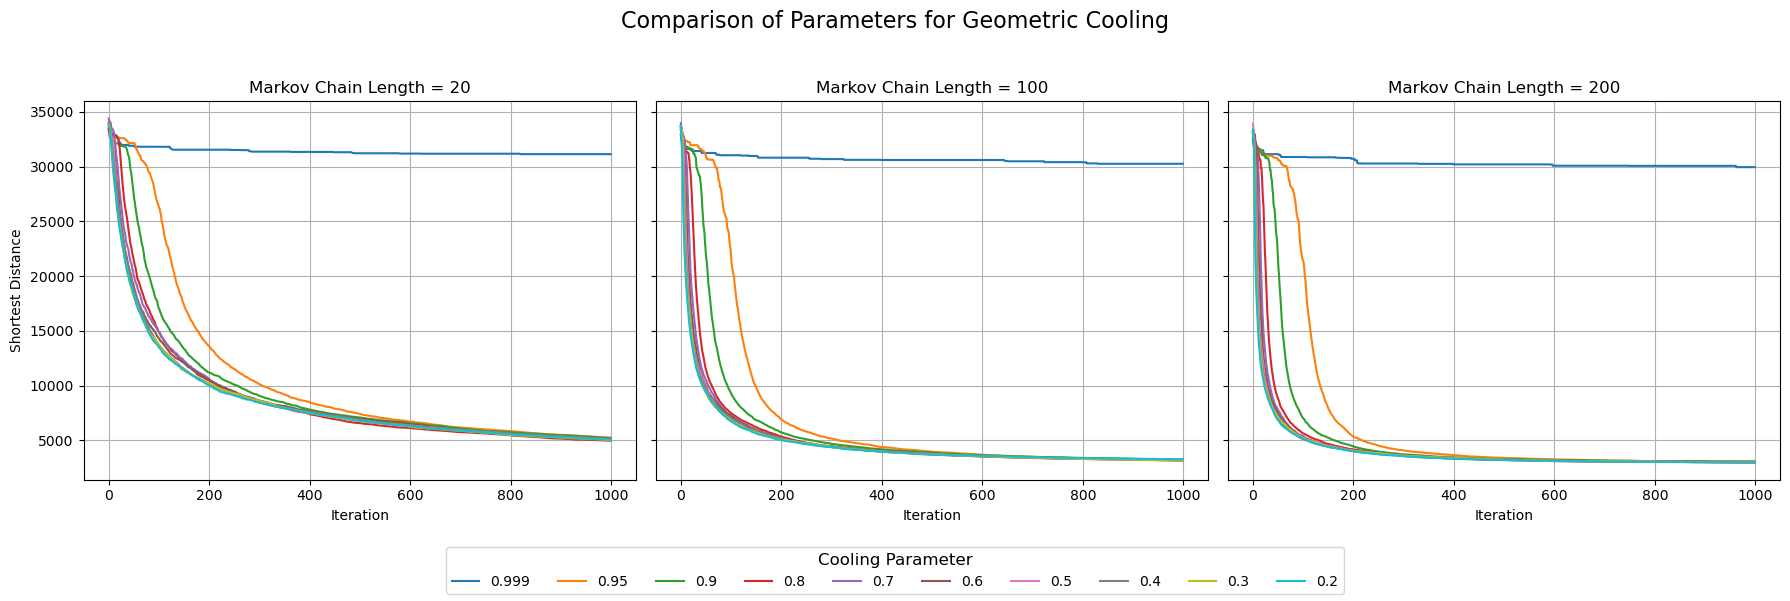

In [73]:
# Fix the Seed for Reproductiability
random.seed(100)
np.random.seed(100)

# Best Solution Collector
best_sol = {"param": None,
            "markov_chain_length": None,
            "iteration_reached": None,
            "value": 50000}

# Specific Settings
cooling_rates = [0.999, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Store the handles and labels for the legend
handles, labels = [], []

for i, markov_chain_length in enumerate(markov_chain_lengths):
    ax = axes[i]
    for param in cooling_rates:
        dist_collection = []
        shortest_distance = 50000
        for _ in range(n_rerun):
            best_tour_exp, shortest_distance_exp, distances_exp = simulated_annealing(coords,
                                                                                      initial_temp,
                                                                                      cooling_schedule_geometric,
                                                                                      param,
                                                                                      max_iterations,
                                                                                      markov_chain_length)
            dist_collection.append(distances_exp)
            shortest_distance = min(shortest_distance, shortest_distance_exp)
            print("check")

        # Compute the mean distances across reruns
        mean_distances = np.mean(np.array(dist_collection), axis=0)
        line, = ax.plot(list(range(mean_distances.shape[0])), mean_distances, label=f"{param}")
        print(f"param {param} finished with lowest value of {shortest_distance}")

        shortest_average = np.min(mean_distances)
        if shortest_average < best_sol['value']:
                best_sol['value'] = shortest_average
                best_sol['param'] = param
                best_sol['markov_chain_length'] = markov_chain_length
                best_sol['iteration_reached'] = np.where(mean_distances == shortest_average)[0][0]
                
        if i==0:
            handles.append(line)
            labels.append(f"{param}")

    # Customize the subplot
    ax.set_title(f"Markov Chain Length = {markov_chain_length}")
    ax.set_xlabel("Iteration")
    # Add a shared y-axis label only for the first subplot
    if i == 0:
        ax.set_ylabel("Shortest Distance")
    ax.grid()
    print(f"Markov Chain Length {markov_chain_length} DONE")

# Add a single legend below all subplots
fig.legend(handles, labels, title="Cooling Parameter", loc="lower center", ncol=len(cooling_rates), fontsize=10, title_fontsize=12)

# Add an overall title
fig.suptitle("Comparison of Parameters for Geometric Cooling", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit the legend

# Save and Show the Final Figure
clear_output()
print("Best (average) solution:")
print(f"Value: {best_sol['value']}")
print(f"Param: {best_sol['param']}")
print(f"Iteration Number: {best_sol['iteration_reached']}")
print(f"Markov Chain: {best_sol['markov_chain_length']}")

plt.savefig(os.path.join(temp_output_loc, "geometric_cooling_params_long.png"), dpi=500)
plt.show()

##### Linear Cooling

Best (average) solution:
Value: 2975.4746304153505
Param: 500
Iteration Number: 996
Markov Chain: 200


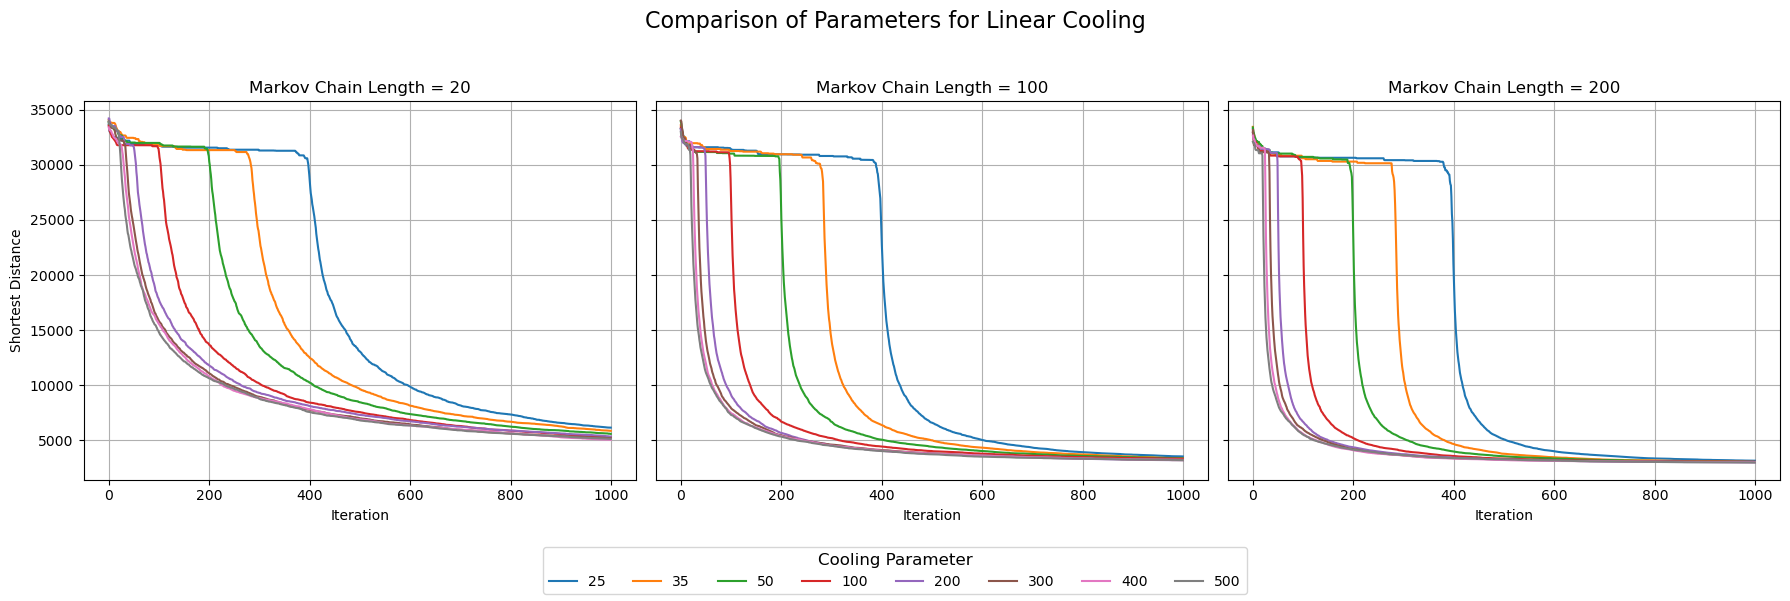

In [74]:
# Fix the Seed for Reproductiability
random.seed(100)
np.random.seed(100)

# Best Solution Collector
best_sol = {"param": None,
            "markov_chain_length": None,
            "iteration_reached": None,
            "value": 50000}

# Specific Settings
cooling_rates = [25, 35, 50, 100, 200, 300, 400, 500]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Store the handles and labels for the legend
handles, labels = [], []

for i, markov_chain_length in enumerate(markov_chain_lengths):
    ax = axes[i]
    for param in cooling_rates:
        dist_collection = []
        shortest_distance = 50000
        for _ in range(n_rerun):
            best_tour_exp, shortest_distance_exp, distances_exp = simulated_annealing(coords,
                                                                                      initial_temp,
                                                                                      cooling_schedule_linear,
                                                                                      param,
                                                                                      max_iterations,
                                                                                      markov_chain_length)
            dist_collection.append(distances_exp)
            shortest_distance = min(shortest_distance, shortest_distance_exp)
            print("check")

        # Compute the mean distances across reruns
        mean_distances = np.mean(np.array(dist_collection), axis=0)
        line, = ax.plot(list(range(mean_distances.shape[0])), mean_distances, label=f"{param}")
        print(f"param {param} finished with lowest value of {shortest_distance}")

        shortest_average = np.min(mean_distances)
        if shortest_average < best_sol['value']:
                best_sol['value'] = shortest_average
                best_sol['param'] = param
                best_sol['markov_chain_length'] = markov_chain_length
                best_sol['iteration_reached'] = np.where(mean_distances == shortest_average)[0][0]
                
        if i==0:
            handles.append(line)
            labels.append(f"{param}")

    # Customize the subplot
    ax.set_title(f"Markov Chain Length = {markov_chain_length}")
    ax.set_xlabel("Iteration")
    # Add a shared y-axis label only for the first subplot
    if i == 0:
        ax.set_ylabel("Shortest Distance")
    ax.grid()
    print(f"Markov Chain Length {markov_chain_length} DONE")

# Add a single legend below all subplots
fig.legend(handles, labels, title="Cooling Parameter", loc="lower center", ncol=len(cooling_rates), fontsize=10, title_fontsize=12)

# Add an overall title
fig.suptitle("Comparison of Parameters for Linear Cooling", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit the legend

# Save and Show the Final Figure
clear_output()
print("Best (average) solution:")
print(f"Value: {best_sol['value']}")
print(f"Param: {best_sol['param']}")
print(f"Iteration Number: {best_sol['iteration_reached']}")
print(f"Markov Chain: {best_sol['markov_chain_length']}")

plt.savefig(os.path.join(temp_output_loc, "linear_cooling_params_long.png"), dpi=500)
plt.show()

##### Logarithmic Cooling

Best (average) solution:
Value: 2975.270238536806
Param: 800
Iteration Number: 998
Markov Chain: 200


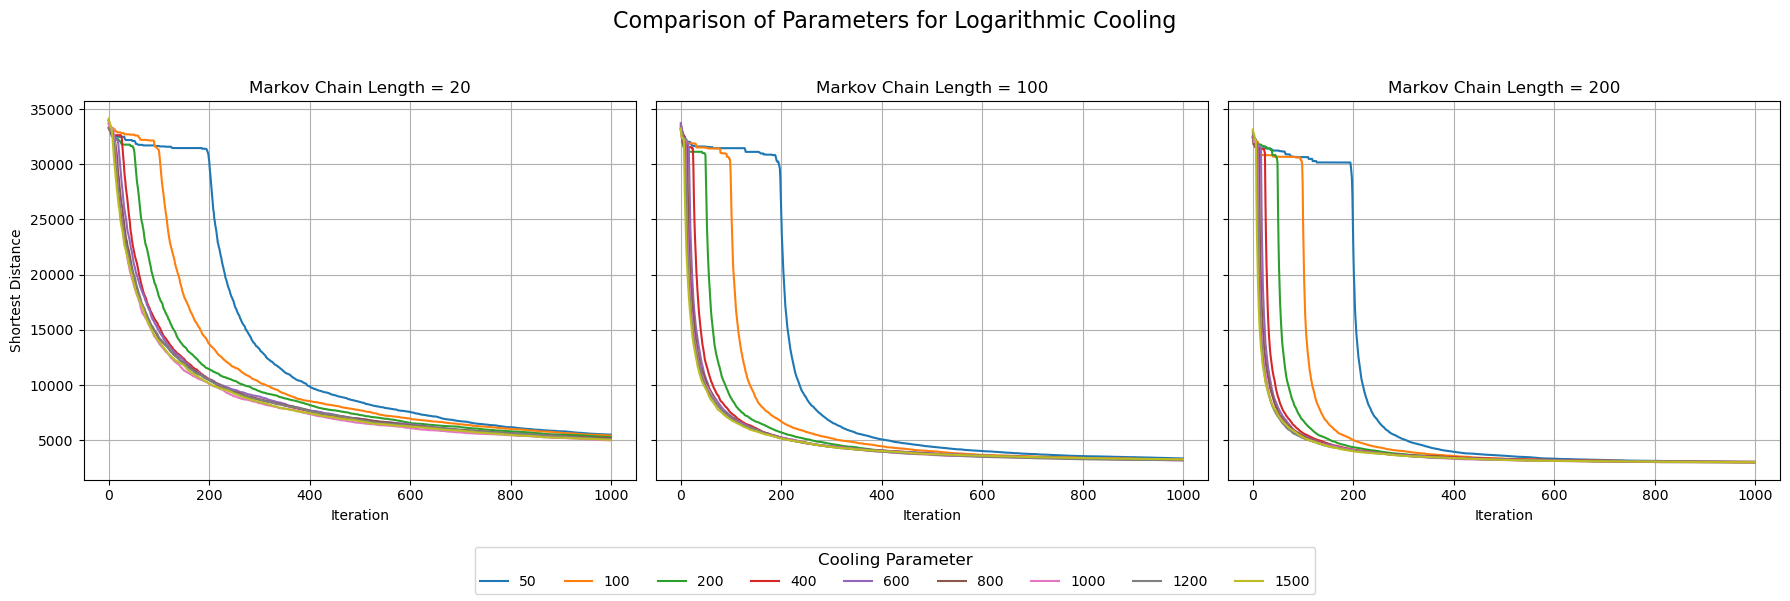

In [75]:
# Fix the Seed for Reproductiability
random.seed(100)
np.random.seed(100)

# Best Solution Collector
best_sol = {"param": None,
            "markov_chain_length": None,
            "iteration_reached": None,
            "value": 50000}

# Specific Settings
cooling_rates = [50, 100, 200, 400, 600, 800, 1000, 1200, 1500]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Store the handles and labels for the legend
handles, labels = [], []

for i, markov_chain_length in enumerate(markov_chain_lengths):
    ax = axes[i]
    for param in cooling_rates:
        dist_collection = []
        shortest_distance = 50000
        for _ in range(n_rerun):
            best_tour_exp, shortest_distance_exp, distances_exp = simulated_annealing(coords,
                                                                                      initial_temp,
                                                                                      cooling_schedule_linear,
                                                                                      param,
                                                                                      max_iterations,
                                                                                      markov_chain_length)
            dist_collection.append(distances_exp)
            shortest_distance = min(shortest_distance, shortest_distance_exp)
            print("check")

        # Compute the mean distances across reruns
        mean_distances = np.mean(np.array(dist_collection), axis=0)
        line, = ax.plot(list(range(mean_distances.shape[0])), mean_distances, label=f"{param}")
        print(f"param {param} finished with lowest value of {shortest_distance}")

        shortest_average = np.min(mean_distances)
        if shortest_average < best_sol['value']:
                best_sol['value'] = shortest_average
                best_sol['param'] = param
                best_sol['markov_chain_length'] = markov_chain_length
                best_sol['iteration_reached'] = np.where(mean_distances == shortest_average)[0][0]
                
        if i==0:
            handles.append(line)
            labels.append(f"{param}")

    # Customize the subplot
    ax.set_title(f"Markov Chain Length = {markov_chain_length}")
    ax.set_xlabel("Iteration")
    # Add a shared y-axis label only for the first subplot
    if i == 0:
        ax.set_ylabel("Shortest Distance")
    ax.grid()
    print(f"Markov Chain Length {markov_chain_length} DONE")

# Add a single legend below all subplots
fig.legend(handles, labels, title="Cooling Parameter", loc="lower center", ncol=len(cooling_rates), fontsize=10, title_fontsize=12)

# Add an overall title
fig.suptitle("Comparison of Parameters for Logarithmic Cooling", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit the legend

# Save and Show the Final Figure
clear_output()
print("Best (average) solution:")
print(f"Value: {best_sol['value']}")
print(f"Param: {best_sol['param']}")
print(f"Iteration Number: {best_sol['iteration_reached']}")
print(f"Markov Chain: {best_sol['markov_chain_length']}")

plt.savefig(os.path.join(temp_output_loc, "logarithmic_cooling_params_long.png"), dpi=500)
plt.show()

##### Reciprocal Cooling

Best (average) solution:
Value: 2974.423206284022
Param: 75
Iteration Number: 995
Markov Chain: 200


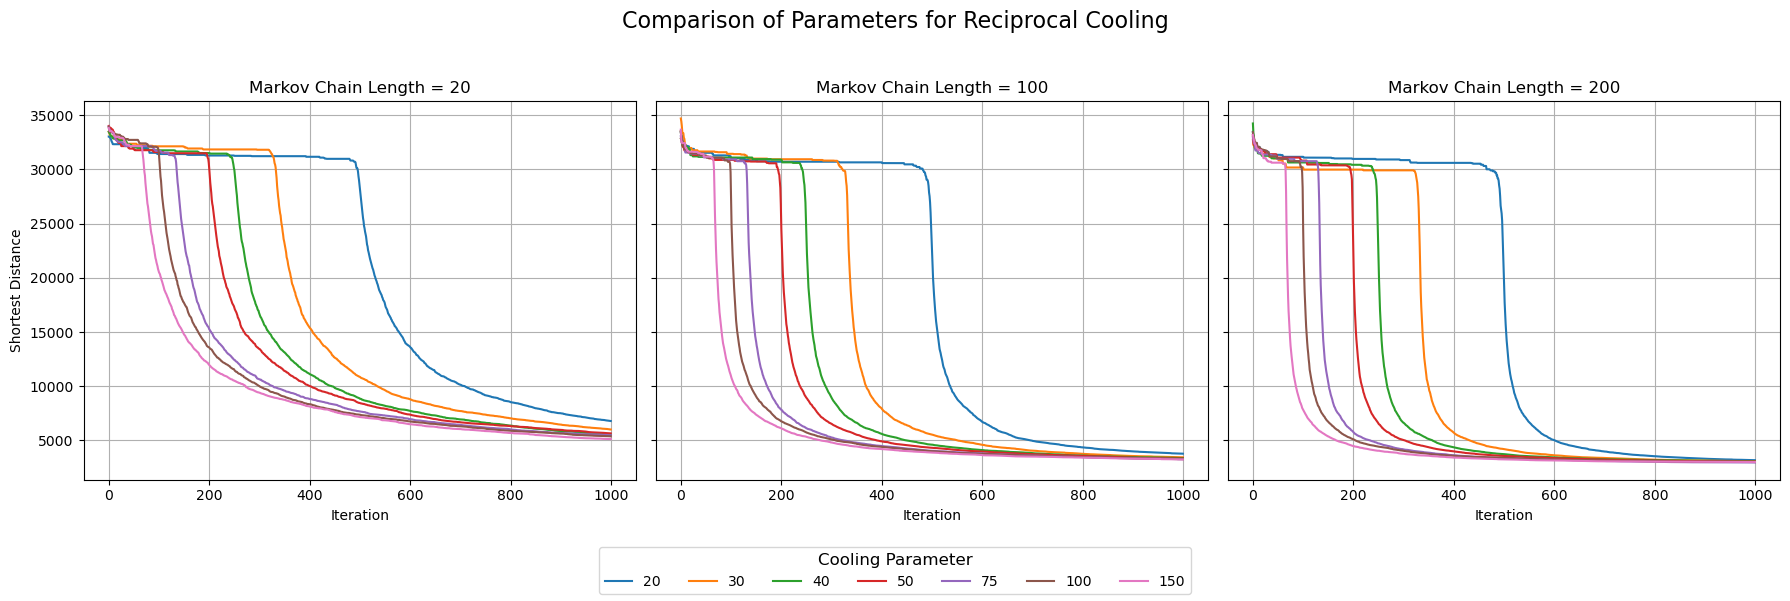

In [76]:
# Fix the Seed for Reproductiability
random.seed(100)
np.random.seed(100)

# Best Solution Collector
best_sol = {"param": None,
            "markov_chain_length": None,
            "iteration_reached": None,
            "value": 50000}

# Specific Settings
cooling_rates = [20, 30, 40, 50, 75, 100, 150]

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Store the handles and labels for the legend
handles, labels = [], []

for i, markov_chain_length in enumerate(markov_chain_lengths):
    ax = axes[i]
    for param in cooling_rates:
        dist_collection = []
        shortest_distance = 50000
        for _ in range(n_rerun):
            best_tour_exp, shortest_distance_exp, distances_exp = simulated_annealing(coords,
                                                                                      initial_temp,
                                                                                      cooling_schedule_linear,
                                                                                      param,
                                                                                      max_iterations,
                                                                                      markov_chain_length)
            dist_collection.append(distances_exp)
            shortest_distance = min(shortest_distance, shortest_distance_exp)
            print("check")

        # Compute the mean distances across reruns
        mean_distances = np.mean(np.array(dist_collection), axis=0)
        line, = ax.plot(list(range(mean_distances.shape[0])), mean_distances, label=f"{param}")
        print(f"param {param} finished with lowest value of {shortest_distance}")

        shortest_average = np.min(mean_distances)
        if shortest_average < best_sol['value']:
                best_sol['value'] = shortest_average
                best_sol['param'] = param
                best_sol['markov_chain_length'] = markov_chain_length
                best_sol['iteration_reached'] = np.where(mean_distances == shortest_average)[0][0]

        if i==0:
            handles.append(line)
            labels.append(f"{param}")

    # Customize the subplot
    ax.set_title(f"Markov Chain Length = {markov_chain_length}")
    ax.set_xlabel("Iteration")
    # Add a shared y-axis label only for the first subplot
    if i == 0:
        ax.set_ylabel("Shortest Distance")
    ax.grid()
    print(f"Markov Chain Length {markov_chain_length} DONE")

# Add a single legend below all subplots
fig.legend(handles, labels, title="Cooling Parameter", loc="lower center", ncol=len(cooling_rates), fontsize=10, title_fontsize=12)

# Add an overall title
fig.suptitle("Comparison of Parameters for Reciprocal Cooling", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit the legend

# Save and Show the Final Figure
clear_output()
print("Best (average) solution:")
print(f"Value: {best_sol['value']}")
print(f"Param: {best_sol['param']}")
print(f"Iteration Number: {best_sol['iteration_reached']}")
print(f"Markov Chain: {best_sol['markov_chain_length']}")

plt.savefig(os.path.join(temp_output_loc, "reciprocal_cooling_params_long.png"), dpi=500)
plt.show()

## Estimating the Best Solution to the TSP

Best Solution is 2806.9787000038364


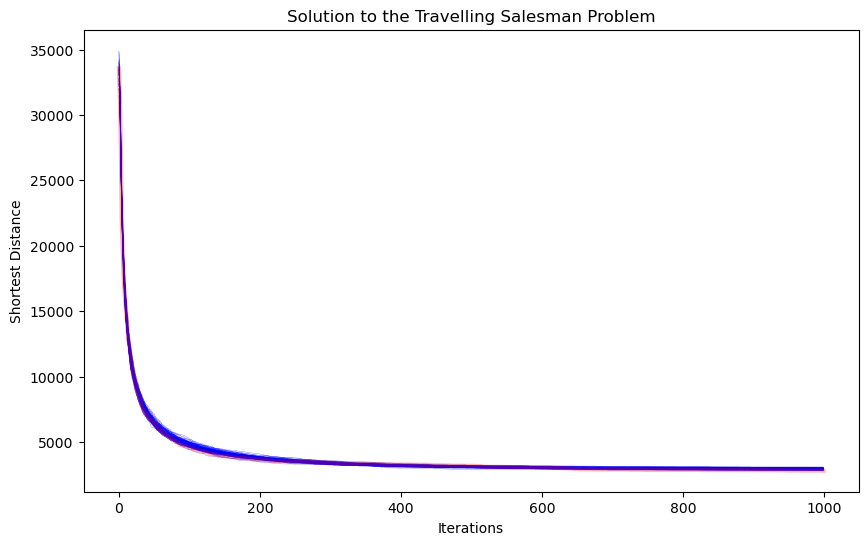

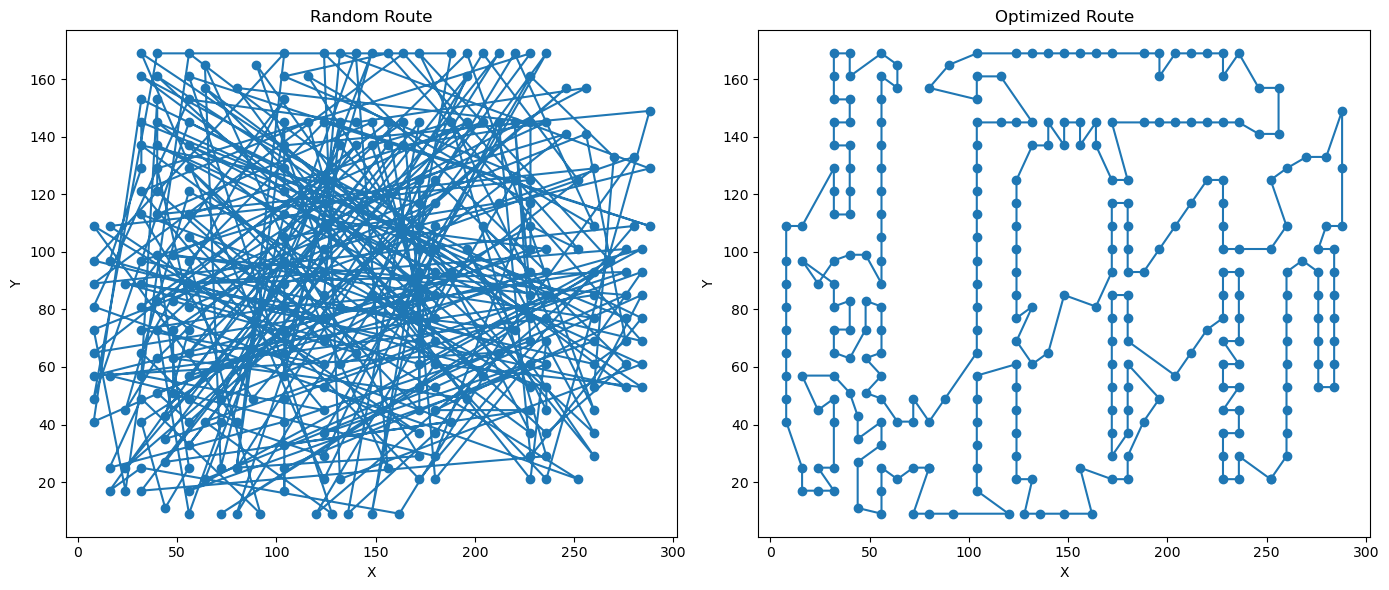

In [82]:
# General Settings
initial_temp = 10000
max_iterations = 1000
n_rerun = 100
markov_chain_length = 250

# Fix the Seed for Reproductiability
random.seed(100)
np.random.seed(100)

# Specific Settings
cooling_rate = 75

# Best Solution Collector
best_solution = {"value": 50000, "best_tour": None, "distances": None}

plt.figure(figsize=(10, 6))

for i in range(n_rerun):
    best_tour_exp, shortest_distance_exp, distances_exp = simulated_annealing(coords,
                                                                              initial_temp,
                                                                              cooling_schedule_reciprocal,
                                                                              cooling_rate,
                                                                              max_iterations,
                                                                              markov_chain_length)
    if shortest_distance_exp < best_solution['value']:
        best_solution['value'] = shortest_distance_exp
        best_solution['best_tour'] = best_tour_exp
        best_solution['distances'] = distances_exp

    print(f"{i}th run done")

    plt.plot(list(range(len(distances_exp))), distances_exp, color='blue', alpha=0.75, linewidth=0.2)

plt.plot(list(range(len(best_solution['distances']))), best_solution['distances'], color='red', alpha=0.3, linewidth=3)

plt.title("Solution to the Travelling Salesman Problem")
plt.xlabel("Iterations")
plt.ylabel("Shortest Distance")

clear_output()
print(f"Best Solution is {best_solution['value']}")
plt.savefig(os.path.join(temp_output_loc, "solution_to_tsp.png"), dpi=500)
plt.show()

plt.figure(figsize=(14, 6))

# Comparing the best route to a random one
dist_matrix = compute_distance_matrix(coords)
n = len(coords)
random_route = list(range(n))
random.shuffle(random_route)
random_route_distance = total_distance(random_route, dist_matrix)

# Depicting the Random route
plt.subplot(1, 2, 1)
tour_coords2 = coords[random_route + [random_route[0]]]  # Close the loop
plt.plot(tour_coords2[:, 0], tour_coords2[:, 1], 'o-', label=f"Shortest Distance: {random_route_distance}")
plt.title(f'Random Route')
plt.xlabel('X')
plt.ylabel('Y')

# Depicting the Optimized route
plt.subplot(1, 2, 2)
tour_coords1 = coords[list(best_solution['best_tour']) + [best_solution['best_tour'][0]]]  # Close the loop
plt.plot(tour_coords1[:, 0], tour_coords1[:, 1], 'o-', label=f"Shortest Distance: {best_solution['value']}")
plt.title(f'Optimized Route')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.savefig(os.path.join(temp_output_loc, "best_route_comparison.png"), dpi=500)
plt.show()


##### Comparing the Optimal Solution Route to a Random One

In [ ]:
dist_matrix = compute_distance_matrix(coords)
n = len(coords)
random_route = list(range(n))
random.shuffle(random_route)
random_route_distance = total_distance(random_route, dist_matrix)

plt.subplot(1, 2, 1)
tour_coords2 = coords[random_route + [random_route[0]]]  # Close the loop
plt.plot(tour_coords2[:, 0], tour_coords2[:, 1], 'o-', label=f"Shortest Distance: {random_route_distance}")
plt.title(f'Random Route')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
tour_coords1 = coords[list(best_solution['best_tour']) + [best_solution['best_tour'][0]]]  # Close the loop
plt.plot(tour_coords1[:, 0], tour_coords1[:, 1], 'o-', label=f"Shortest Distance: {best_solution['value']}")
plt.title(f'Optimized Route')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.savefig(os.path.join(temp_output_loc, "best_route_comparison.png"), dpi=500)
plt.show()